In [3]:
#Calculate lensed gradient spectra for CMB lensing responses
#AL Apr 2019, merging code from old "Cgrads" branch
#Flat sky, following http://arxiv.org/abs/1101.2234 - e.g. reproduced Fig 4 to smaller scales
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
#sys.path.insert(0,r'c:\Work\Dist\git\camb')
import camb
print(camb.__version__)
from camb import model, initialpower
from camb import correlations, config
from camb._config import lensing_method_flat_corr, lensing_method_curv_corr

1.3.5


In [4]:
#Use flat sky, get gradient spectra
#pars =camb.set_params(H0=None, cosmomc_theta =0.010411,lmax=4200, lens_potential_accuracy=1)
lmax=8000
pars = camb.CAMBparams()
print(pars.Recomb.RECFAST_fudge)

pars.set_cosmology(H0=67, ombh2=0.022445, omch2=0.1212, mnu=0)
pars.InitPower.set_params(As=2.1265e-09, ns=0.96)

# reionization and recombination 
pars.Reion.use_optical_depth = True
pars.Reion.optical_depth = 0.0925
pars.Reion.delta_redshift = 0.5
pars.Recomb.RECFAST_fudge = 1.14

# accuracy
pars.set_for_lmax(lmax+200, lens_potential_accuracy=4)

#non linearity
pars.NonLinear = model.NonLinear_both
pars.NonLinearModel.halofit_version = 'takahashi'
pars.Accuracy.AccurateBB = True #need this to avoid small-scale ringing
#config.lensing_method=lensing_method_curv_corr
#%time data1=camb.get_results(pars)
config.lensing_method=lensing_method_flat_corr # default

%time data=camb.get_results(pars)

CT = data.get_lensed_scalar_cls(CMB_unit='muK')
CTun = data.get_unlensed_scalar_cls(CMB_unit='muK')
#print CT[2:,0].shape,l[2:6901].shape
datadic=data.get_cmb_unlensed_scalar_array_dict(CMB_unit='muK')

l=np.arange(len(datadic['TxT']))
ClsUtest = np.array([l[2:],datadic['TxT'][2:],datadic['ExE'][2:],np.zeros(len(l))[2:],datadic['TxE'][2:],datadic['PxP'][2:],datadic['PxT'][2:],datadic['PxE'][2:]])
ClsLtest = np.array([l[2:6901],CT[2:,0],CT[2:,1],CT[2:,2],CT[2:,3]])
np.savetxt('new_lensedCMB_dmn1_lenspotentialCls.dat',ClsUtest.transpose(),fmt='%d\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e')
np.savetxt('new_lensedCMB_dmn1_lensedCls.dat',ClsLtest.transpose(),fmt='%d\t%.5e\t%.5e\t%.5e\t%.5e')

1.125
CPU times: user 55.6 s, sys: 509 ms, total: 56.1 s
Wall time: 4.26 s


4000 3999 8351 6901


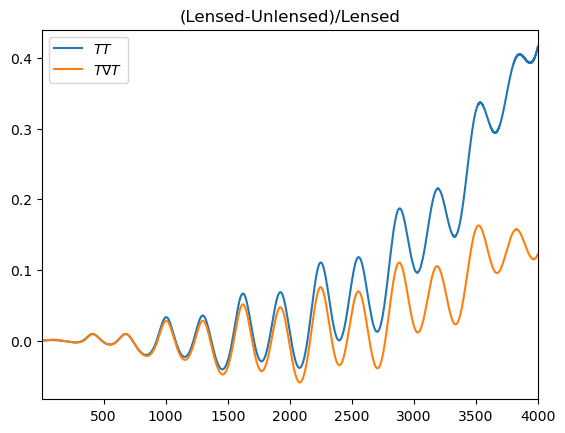

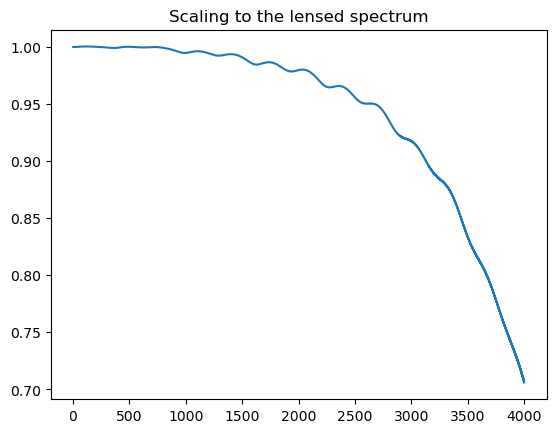

In [5]:
clgrad = data.get_lensed_gradient_cls(CMB_unit='muK')
ClsGradtest = np.array([l[2:6901],clgrad[2:,0],clgrad[2:,1],clgrad[2:,2],clgrad[2:,3],clgrad[2:,4],clgrad[2:,5]])
np.savetxt('new_lensedCMB_dmn1_lensedgradCls.dat',ClsGradtest.transpose(),fmt='%d\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e\t%.5e')
CT = data.get_lensed_scalar_cls(CMB_unit='muK')
CTun = data.get_unlensed_scalar_cls(CMB_unit='muK')
lmax=4000
ls = np.arange(2,lmax+1)

print(lmax,len(ls), len(1-CTun[:,0]), len(CT[:,0])) 
plt.plot(ls, 1-CTun[2:lmax+1,0]/CT[2:lmax+1,0])
plt.plot(ls, (clgrad[2:lmax+1,0]-CTun[2:lmax+1,0])/CT[2:lmax+1,0])
plt.title('(Lensed-Unlensed)/Lensed')
plt.legend(['$TT$',r'$T\nabla T$'])
plt.xlim([2,lmax])
plt.figure()
plt.plot(ls, clgrad[2:lmax+1,0]/CT[2:lmax+1,0])
plt.title('Scaling to the lensed spectrum');

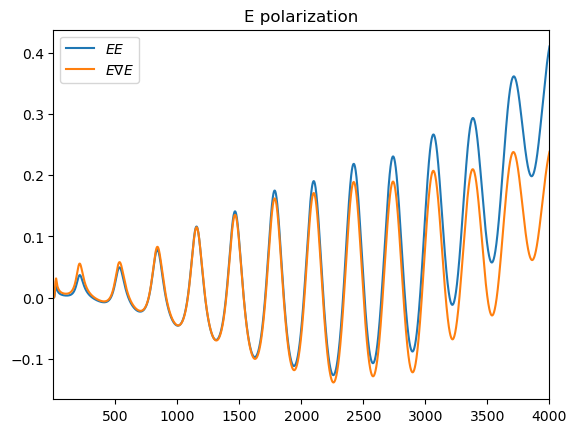

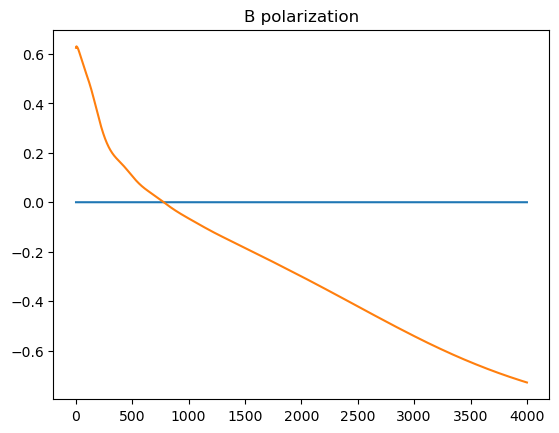

In [6]:
plt.plot(ls, 1-CTun[2:lmax+1,1]/CT[2:lmax+1,1])
plt.plot(ls, (clgrad[2:lmax+1,1]-CTun[2:lmax+1,1])/CT[2:lmax+1,1])
plt.title('E polarization');
plt.legend(['$EE$',r'$E\nabla E$'])
plt.xlim([2,lmax])

plt.figure()
plt.plot(ls, 1-CTun[2:lmax+1,2]/CT[2:lmax+1,2] -1)
plt.plot(ls, (clgrad[2:lmax+1,2]-CTun[2:lmax+1,2])/CT[2:lmax+1,2] -1)
plt.title('B polarization');

In [19]:
from scipy.interpolate import InterpolatedUnivariateSpline
lmin=2

Ls= np.concatenate((np.array([2,5, 10,25], dtype=np.float64),
                np.arange(50,lmax-20,30, dtype=np.float64), np.asarray([lmax-15, lmax]) ))

cTT = InterpolatedUnivariateSpline(ls,CT[2:lmax+1,0]/ls/(ls+1)*2*np.pi)
cTTgrad = InterpolatedUnivariateSpline(ls,clgrad[2:lmax+1,0]/ls/(ls+1)*2*np.pi)


if False:#S4
    experiment='S4'
    xlc= 180*np.sqrt(8.*np.log(2.))/np.pi
    sigma2 = (1./60/xlc)**2
    noise = (1*np.pi/180./60)**2*np.exp(ls*(ls+1)*sigma2)
else:
    experiment='SO'
    SO_Noise = np.loadtxt(r'/Users/fabbian/Work/n32_cmb/SO_LAT_Nell_goal_fsky0p4_ILC_CMB.dat')
    SO_Noise[0:40,:]=0
    noise = SO_Noise[2:lmax+1,0]
    #noise[2999:]=1.0e10 # set this line to  compute A_L up to L=4000 while using CMB modes up to lmax=3000.
cTTobs = InterpolatedUnivariateSpline(ls,CT[2:lmax+1,0]/ls/(ls+1)*2*np.pi + noise)
cTTgrad_obs = InterpolatedUnivariateSpline(ls,clgrad[2:lmax+1,0]/ls/(ls+1)*2*np.pi + noise)

def get_response(lmaxTT = 4000):
    Nzero = np.zeros(Ls.shape)
    resp = np.zeros(Ls.shape)
    resp_grad = np.zeros(Ls.shape)
    resp_gradgrad = np.zeros(Ls.shape)
    resp_gradgradgrad = np.zeros(Ls.shape)    
    dL = 5
    for ix,L in enumerate(Ls):
        Lsamp=  np.arange(lmin,lmaxTT+1, dL, dtype=np.float64)
        resp_L = np.zeros(Lsamp.shape)
        resp_grad_L = np.zeros(Lsamp.shape)
        resp_gradgrad_L = np.zeros(Lsamp.shape)
        resp_gradgradgrad_L = np.zeros(Lsamp.shape)        
        for i, l in enumerate(Lsamp):
            nphi= max(32,2*int(l)+1) 
            nphi=min(nphi,128) 
            dphi=(2*np.pi/nphi)
            phi = np.linspace(0,2*np.pi, nphi, endpoint =False)
            cos = np.cos(phi)
            weight = dphi*l/(2*np.pi)**2 
            l3 = np.sqrt(L**2+l**2 -2*L*l*cos)

            response =((-L*l*cos + L**2)*cTT(l3) + (L*l*cos)*cTT(l))  
            response_grad =((-L*l*cos + L**2)*cTTgrad(l3) + (L*l*cos)*cTTgrad(l))
            
            filter = 1/(cTTobs(l)*cTTobs(l3))
            filter[l3<lmin]=0
            filter[l3>lmaxTT]=0
            
            filter_grad = 1/(cTTgrad_obs(l)*cTTgrad_obs(l3))            
            #filter_grad = 1/(cTTobs(l)*cTTobs(l3))
            filter_grad[l3<lmin]=0
            filter_grad[l<lmin]=0            
            filter_grad[l3>lmaxTT]=0
            
            g = response*filter
            g_grad = response*filter_grad             
            g_gradgrad = response_grad*filter
            
            resp_L[i] = np.dot(g,response)*weight   
            resp_grad_L[i] = np.dot(g,response_grad)*weight   
            resp_gradgrad_L[i] = np.dot(g_grad,response_grad)*weight  
            resp_gradgradgrad_L[i] = np.dot(g_gradgrad,response_grad)*weight            
            
        resp[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))
        resp_grad[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_grad_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))
        resp_gradgrad[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_gradgrad_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))
        resp_gradgradgrad[ix] = np.sum(InterpolatedUnivariateSpline(Lsamp, resp_gradgradgrad_L,ext=1)(np.arange(Lsamp[0],Lsamp[-1])))        
        
    return resp, resp_grad, resp_gradgrad,resp_gradgradgrad
lmaxTT=lmax
print '%s lmaxTT = %d lmax =%d'%(experiment,lmaxTT,lmax),lmaxTT,lmax
#resp, resp_grad = get_response(lmaxTT)
resp, resp_grad, resp_gradgrad, resp_gradgradgrad = get_response(lmaxTT=4000)


SO lmaxTT = 4000 lmax =4000 4000 4000


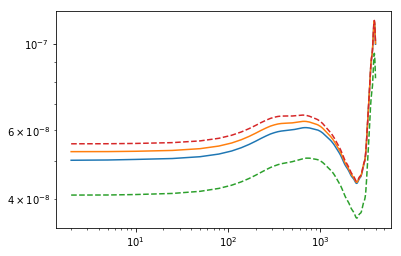

In [52]:
plt.loglog(Ls,Ls**4/resp)
plt.loglog(Ls,Ls**4/resp_grad)
plt.loglog(Ls,Ls**4/resp_gradgrad,linestyle='--')
plt.loglog(Ls,Ls**4/resp_gradgradgrad,linestyle='--')
#print resp_gradgrad/resp_grad

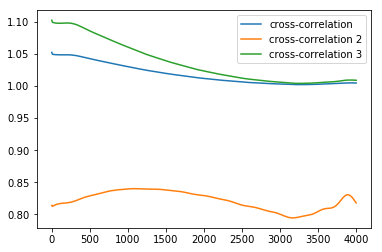

In [53]:
#plt.plot(Ls,(resp_grad/resp)**-2,label='auto')
plt.plot(Ls,(resp_grad/resp)**-1,label='cross-correlation')
plt.plot(Ls,(resp_gradgrad/resp)**-1,label='cross-correlation 2')
plt.plot(Ls,(resp_gradgradgrad/resp)**-1,label='cross-correlation 3')
plt.legend()

In [20]:
resp_grad_int = InterpolatedUnivariateSpline(Ls, resp_grad,ext=1)(ls)
resp_int = InterpolatedUnivariateSpline(Ls, resp,ext=1)(ls)
#np.savetxt('A_L_%s_phi_normalization_lmax%d_dmn1.dat'%(experiment,lmaxTT),np.array([ls,1/resp_grad_int,1/resp_int,(resp_grad_int/resp_int)**-1]).transpose(),header='L A_L_Cgrad A_L A_L_Cgrad/A_L')
np.savetxt('A_L_%s_phi_normalization_lmax%d_lmaxTT3000.dat'%(experiment,lmaxTT),np.array([ls,1/resp_grad_int,1/resp_int,(resp_grad_int/resp_int)**-1]).transpose(),header='L A_L_Cgrad A_L A_L_Cgrad/A_L')

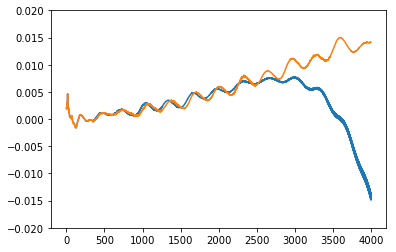

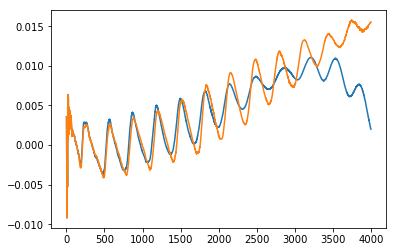

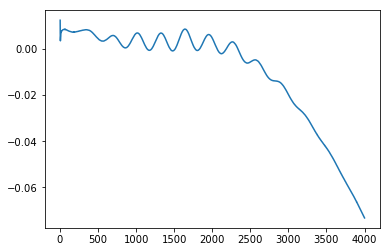

In [57]:
dmn1=np.loadtxt('/Users/fabbian/Dropbox/lens2hat-raytrace/PerGiulio/CAMB_DEMNUni/lensedCMB_int_lensedCls.dat', unpack=True)
dmn1u=np.loadtxt('/Users/fabbian/Dropbox/lens2hat-raytrace/PerGiulio/CAMB_DEMNUni/lensedCMB_int_lenspotentialCls.dat', unpack=True)
plt.plot(dmn1[0][:3999],dmn1[1][:3999]/CT[2:lmax+1,0] -1)
plt.plot(dmn1[0][:3999],dmn1u[1][:3999]/CTun[2:lmax+1,0] -1)
#plt.plot(ls,CT[2:lmax+1,0])
plt.ylim(-0.02,0.02)

plt.figure()
plt.plot(dmn1[0][:3999],dmn1[2][:3999]/CT[2:lmax+1,1] -1)
plt.plot(dmn1[0][:3999],dmn1u[2][:3999]/CTun[2:lmax+1,1] -1)

plt.figure()
plt.plot(dmn1[0][:3999],dmn1[3][:3999]/CT[2:lmax+1,2] -1)


#s4=np.loadtxt('A_L_S4_phi_normalization_lmax4000.dat',unpack=True)
#s4_tau=np.loadtxt('A_L_S4_phi_normalization_lmax4000_dmn1.dat',unpack=True)
#plt.plot(s4[0],s4_tau[3]/s4[3] -1)